In [27]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

In [28]:
merged_df = pd.read_csv('../Data/merged.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='mixed', dayfirst=True, errors='coerce')
merged_df = merged_df.sort_values(["Symbol", "Date"])

aapl = merged_df[merged_df["Symbol"] == "AAPL"].copy()

In [29]:
lag_cols   = [f"Close_lag{k}" for k in range(1, 11)]
news_cols  = [c for c in merged_df.columns if c.startswith("News -")]
num_features  = lag_cols + ["Volume"] + news_cols      

merged_df = pd.get_dummies(merged_df, columns=["GICS Sector"], drop_first=True, dtype="int")

sector_dummies = [c for c in merged_df.columns if c.startswith("GICS Sector_")]
feature_cols   = num_features + sector_dummies

cutoff_date = merged_df["Date"].quantile(0.8)

train = merged_df[merged_df["Date"] <= cutoff_date]
test  = merged_df[merged_df["Date"]  > cutoff_date]

X_train, y_train = train[feature_cols], train["Profit"]
X_test,  y_test  = test [feature_cols], test ["Profit"]

In [30]:
# Change to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test.values,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)

train_dl = DataLoader(TensorDataset(X_train_t, y_train_t),
                      batch_size=256, shuffle=True)

In [31]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)      # logits
        )
    def forward(self, x): return self.net(x)

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = MLP(X_train.shape[1]).to(device)
loss_fn  = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
epochs = 25
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimiser.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimiser.step()
    if (epoch+1) % 5 == 0:
        print(f"epoch {epoch+1:2d}/{epochs} - loss {loss.item():.4f}")

epoch  5/25 - loss 124.0215
epoch 10/25 - loss 0.7625
epoch 15/25 - loss 0.6985
epoch 20/25 - loss 0.6917
epoch 25/25 - loss 0.6947


In [33]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device)).cpu().numpy().ravel()
    y_prob = 1 / (1 + np.exp(-logits))           # sigmoid
    y_pred = (y_prob > 0.5).astype(int)

print(f"\nAccuracy : {accuracy_score (y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score   (y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score : {f1_score       (y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC  : {roc_auc_score  (y_test, y_prob):.4f}")


Accuracy : 0.4900
Precision: 0.4900
Recall   : 1.0000
F1-score : 0.6577
ROC-AUC  : 0.5000


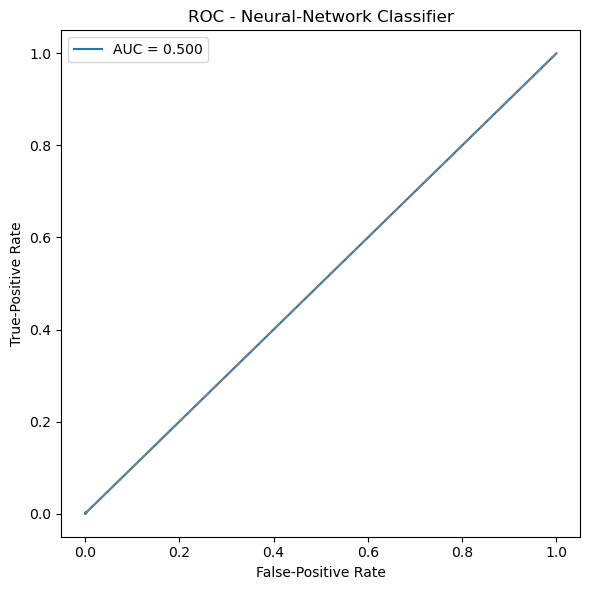

In [34]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False-Positive Rate"); plt.ylabel("True-Positive Rate")
plt.title("ROC - Neural-Network Classifier")
plt.legend(); plt.tight_layout(); plt.show()

In [35]:
lag_cols   = [f"Close_lag{k}" for k in range(1, 11)]
news_cols  = [c for c in aapl.columns if c.startswith("News -")]
num_features  = lag_cols + ["Volume"] + news_cols      

aapl = pd.get_dummies(aapl, columns=["GICS Sector"], drop_first=True, dtype="int")

sector_dummies = [c for c in aapl.columns if c.startswith("GICS Sector_")]
feature_cols   = num_features + sector_dummies

cutoff_date = aapl["Date"].quantile(0.8)

train = aapl[aapl["Date"] <= cutoff_date]
test  = aapl[aapl["Date"]  > cutoff_date]

X_train, y_train = train[feature_cols], train["Profit"]
X_test,  y_test  = test [feature_cols], test ["Profit"]

In [36]:
# Change to tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test.values,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)

train_dl = DataLoader(TensorDataset(X_train_t, y_train_t),
                      batch_size=256, shuffle=True)

In [37]:
# Re-instantiate model and loss function for AAPL-specific data
model = MLP(X_train.shape[1]).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

epochs = 25
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimiser.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimiser.step()
    if (epoch+1) % 5 == 0:
        print(f"epoch {epoch+1:2d}/{epochs} - loss {loss.item():.4f}")

epoch  5/25 - loss 378645.0625
epoch 10/25 - loss 215150.4375
epoch 15/25 - loss 161568.0469
epoch 20/25 - loss 72474.9453
epoch 25/25 - loss 136121.6250


In [38]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t.to(device)).cpu().numpy().ravel()
    y_prob = 1 / (1 + np.exp(-logits))           # sigmoid
    y_pred = (y_prob > 0.5).astype(int)

print(f"\nAccuracy : {accuracy_score (y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score   (y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score : {f1_score       (y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC  : {roc_auc_score  (y_test, y_prob):.4f}")


Accuracy : 0.5000
Precision: 0.5000
Recall   : 1.0000
F1-score : 0.6667
ROC-AUC  : 0.5000


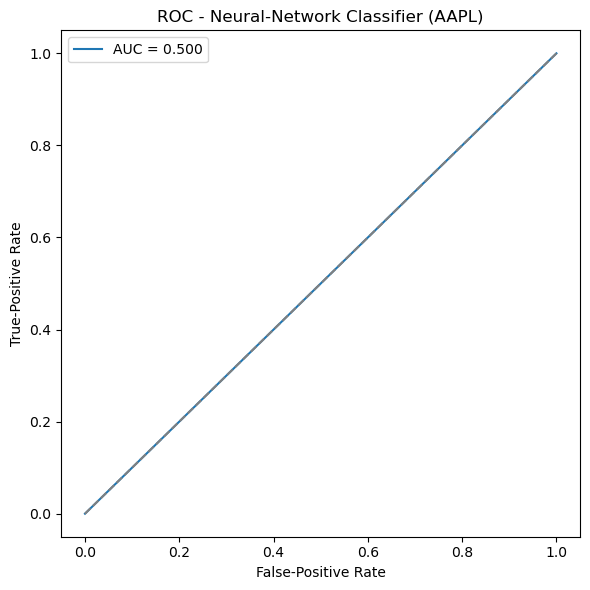

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False-Positive Rate"); plt.ylabel("True-Positive Rate")
plt.title("ROC - Neural-Network Classifier (AAPL)")
plt.legend(); plt.tight_layout(); plt.show()